   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.1 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to animal2-2 in yolov8:: 100%|██████████| 23374/23374 [00:02<00:00, 8067.97it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset loaded: /content/animal2-2/data.yaml
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/animal2-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

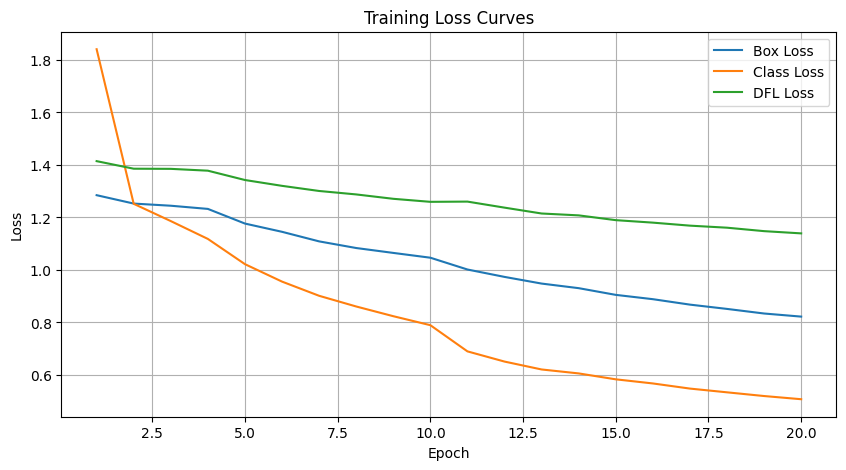

KeyError: 'metrics/mAP50'

<Figure size 1000x500 with 0 Axes>

In [ ]:
# ================================
# 1. INSTALL DEPENDENCIES
# ================================
!pip install ultralytics roboflow matplotlib seaborn pandas -q

# ================================
# 2. DOWNLOAD DATASET FROM ROBOFLOW
# ================================
from roboflow import Roboflow

rf = Roboflow(api_key="lqiMHBOSIqLGCKvZgB67")
project = rf.workspace("pavan-g-hzipt").project("animal2-ps24m")
version = project.version(2)
dataset = version.download("yolov8")

data_yaml = dataset.location + "/data.yaml"
print("Dataset loaded:", data_yaml)

# ================================
# 3. TRAIN YOLOv8s FOR 20 EPOCHS
# ================================
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # Better accuracy than yolov8n

results = model.train(
    data=data_yaml,
    epochs=20,
    imgsz=640,
    batch=16,
    device=0  # set "cpu" if GPU not available
)

print("Training finished!")

# ================================
# 4. EVALUATE MODEL (mAP, Precision, Recall)
# ================================
metrics = model.val()
print(metrics)

# ================================
# 5. CONFUSION MATRIX
# ================================
model.val(save_json=True, save_conf=True, conf=0.25)

# Confusion matrix image will be saved under:
# runs/detect/val/confusion_matrix.png

# ================================
# 6. GENERATE TRAINING CURVES (LOSS, mAP)
# ================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

results_dir = "runs/detect/train"
csv_path = os.path.join(results_dir, "results.csv")

df = pd.read_csv(csv_path)
print(df.head())

# ---- Plot Loss Curves ----
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train/box_loss'], label="Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Class Loss")
plt.plot(df['epoch'], df['train/dfl_loss'], label="DFL Loss")
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# ---- Plot mAP ----
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['metrics/mAP50'], label="mAP50")
plt.plot(df['epoch'], df['metrics/mAP50-95'], label="mAP50-95")
plt.title("mAP Metrics Curve")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid()
plt.show()

# ================================
# 7. CLASSIFICATION REPORT FROM DETECTIONS
# ================================
from sklearn.metrics import classification_report
import json

pred_json = "runs/detect/val/predictions.json"

with open(pred_json) as f:
    data = json.load(f)

y_true = []
y_pred = []

# Extract GT + Predictions per bbox
for item in data:
    if "annotations" in item:
        for ann in item["annotations"]:
            y_true.append(ann["class"])
    if "predictions" in item:
        for pred in item["predictions"]:
            y_pred.append(pred["class"])

# Print classification report
print("\n=========== CLASSIFICATION REPORT ===========\n")
print(classification_report(y_true, y_pred, zero_division=0))

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 975.8±428.1 MB/s, size: 37.2 KB)
val: Scanning /content/animal2-2/valid/labels.cache... 2148 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2148/2148 1.9Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 767, len(boxes) = 9247. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 135/135 3.9it/s 34.3s
                   all       2148       9247      0.911      0.871      0.926      0.706
               Cheetah        201        645       0.91      0.854      0.951      0.707
                baison        177        76

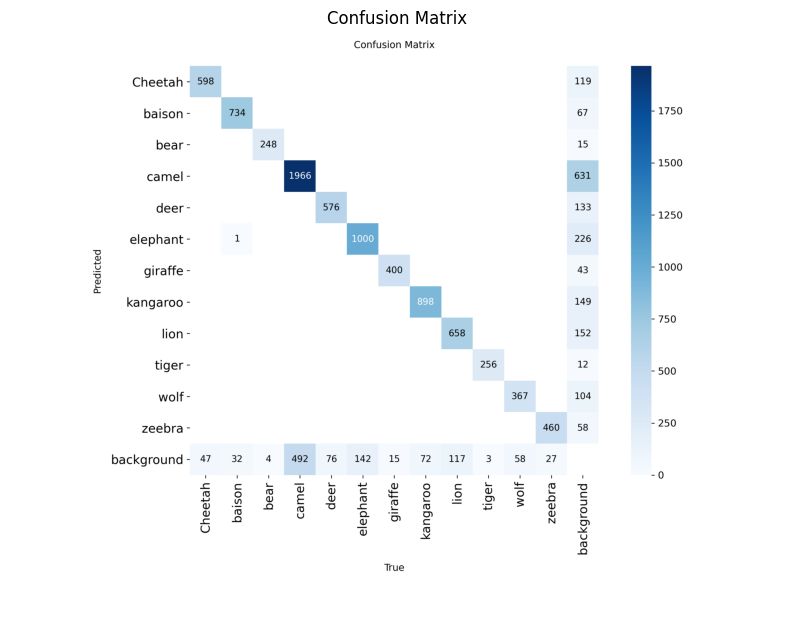

In [ ]:
# ==========================================
# 5. GENERATE CONFUSION MATRIX FOR YOLOv8
# ==========================================

# Run validation again BUT save predictions
val_results = model.val(save_json=True, save_hybrid=True)

print("Validation complete. Predictions saved.")

# The confusion matrix image is automatically saved at:
# runs/detect/val/confusion_matrix.png

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cm_path = "runs/detect/val/confusion_matrix.png"

# Display confusion matrix
img = mpimg.imread(cm_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix")
plt.show()


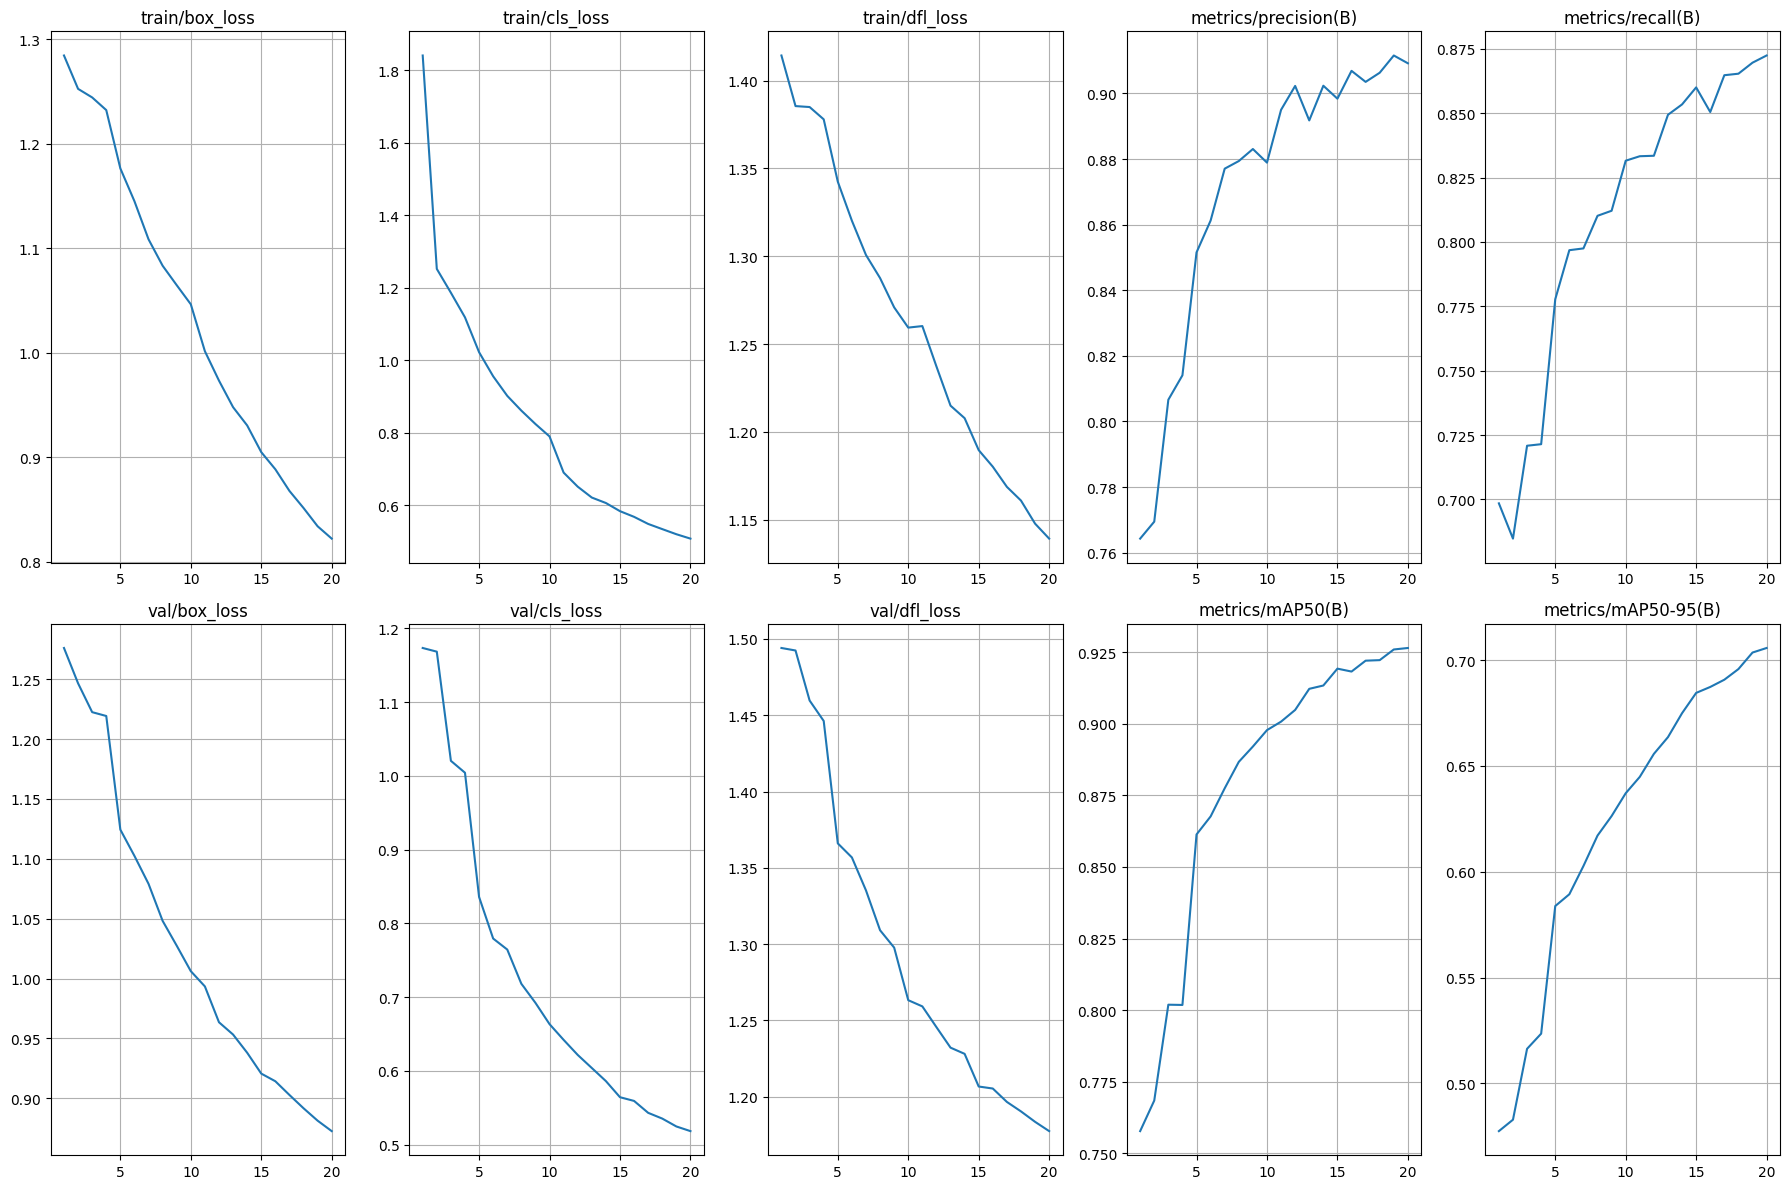

In [ ]:
# ===============================================
# DRAW YOLO TRAINING CURVES EXACTLY LIKE SHOWN
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to YOLO results.csv
csv_path = "runs/detect/train/results.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Select keys to plot
keys = [
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "metrics/precision(B)", "metrics/recall(B)",
    "val/box_loss", "val/cls_loss", "val/dfl_loss",
    "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]

titles = [
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "metrics/precision(B)", "metrics/recall(B)",
    "val/box_loss", "val/cls_loss", "val/dfl_loss",
    "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]

# -----------------------------------------
# Plot 10 subplots exactly like YOLO output
# -----------------------------------------
plt.figure(figsize=(18, 12))

for i, key in enumerate(keys):
    plt.subplot(2, 5, i+1)
    plt.plot(df["epoch"], df[key], label=key)
    plt.title(titles[i])
    plt.grid(True)

plt.tight_layout()
plt.show()

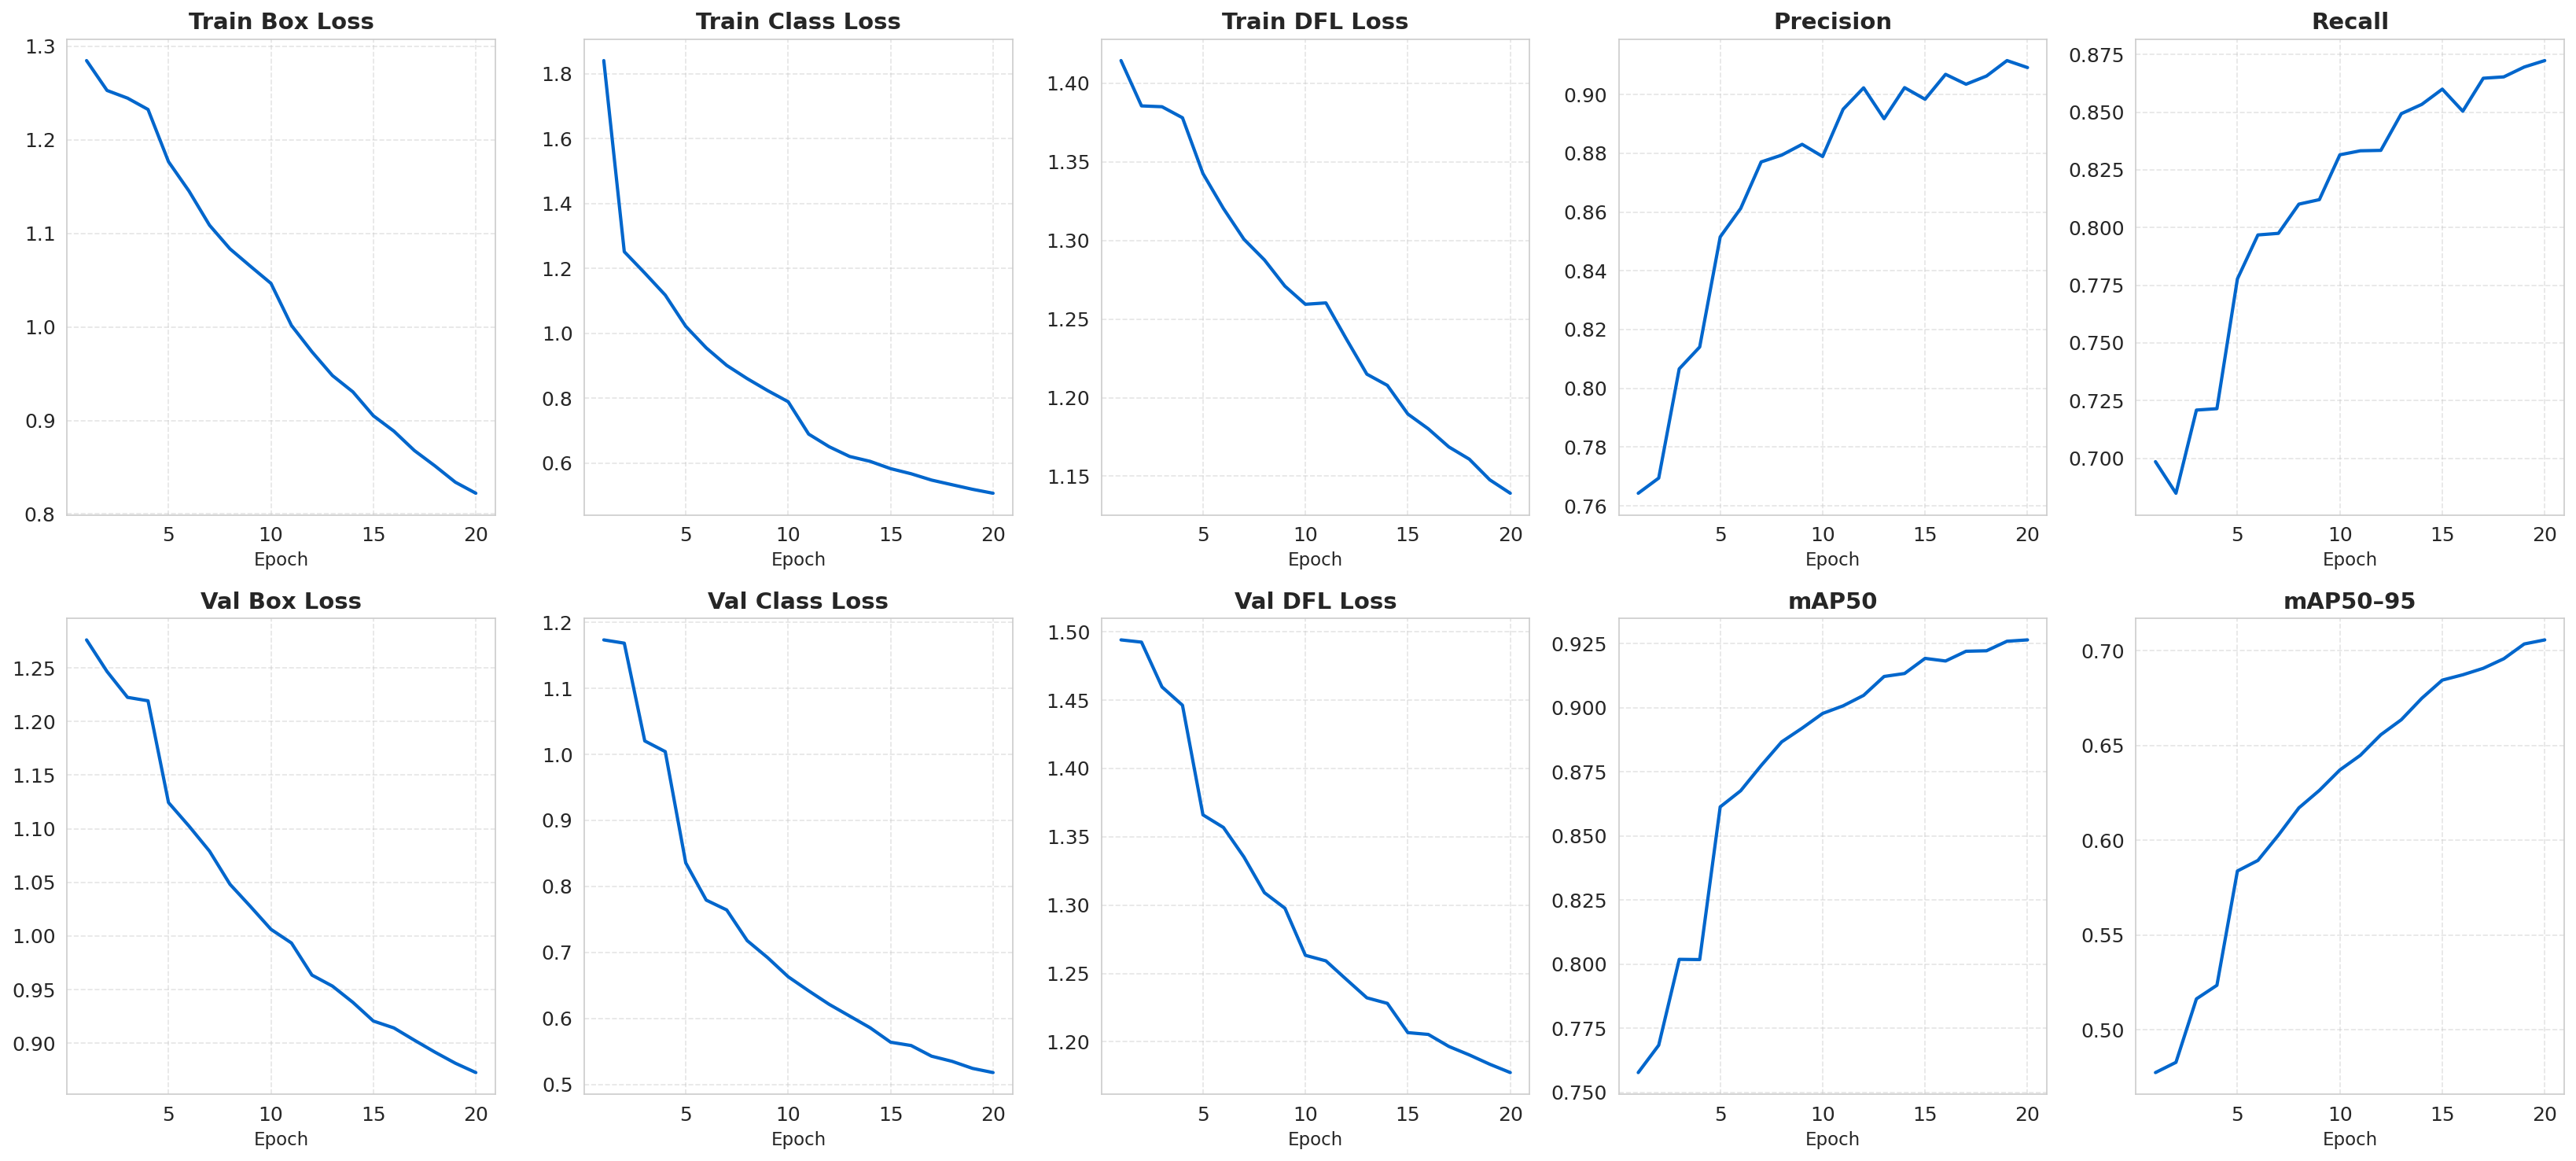

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------
# Load results.csv
# -----------------------------------------
csv_path = "runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

# -----------------------------------------
# High-quality style
# -----------------------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12

metrics = [
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "metrics/precision(B)", "metrics/recall(B)",
    "val/box_loss", "val/cls_loss", "val/dfl_loss",
    "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]

titles = [
    "Train Box Loss", "Train Class Loss", "Train DFL Loss",
    "Precision", "Recall",
    "Val Box Loss", "Val Class Loss", "Val DFL Loss",
    "mAP50", "mAP50–95"
]

# -----------------------------------------
# Create figure
# -----------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

for i, (m, title) in enumerate(zip(metrics, titles)):
    axes[i].plot(df["epoch"], df[m], color="#0066CC", linewidth=2)
    axes[i].set_title(title, fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Epoch", fontsize=11)
    axes[i].set_ylabel("", fontsize=11)
    axes[i].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# ================================================================
# 🚀 RT-DETR TRAINING (20 EPOCHS) — NO FREEZE, REDUCED ITERATIONS
# ================================================================

!pip install ultralytics roboflow matplotlib seaborn scikit-learn --quiet

import os
import yaml
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ultralytics import RTDETR
from roboflow import Roboflow
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------
# 🚫 Disable WANDB Completely
# -----------------------------
os.environ["WANDB_MODE"] = "disabled"

# -----------------------------
# 📌 Step 1: Download Dataset
# -----------------------------
rf = Roboflow(api_key="opwEKPMU0woiZAA96a10")
project = rf.workspace("animaldetection-vpkis").project("rfdter1-wekbl")
version = project.version(1)
dataset = version.download("yolov8")

data_yaml = os.path.join(dataset.location, "data.yaml")
print("✅ Dataset YAML:", data_yaml)

# -----------------------------
# 📌 Step 2: Train RT-DETR Model (FREEZE FIXED)
# -----------------------------
model = RTDETR("rtdetr-l.pt")

model.train(
    data=data_yaml,
    epochs=20,
    imgsz=640,
    batch=16,              # ✅ Fewer iterations
    fraction=0.25,         # ✅ <600 steps
    workers=0,             # 🔥 CRITICAL: prevents freeze
    cache=False,           # 🔥 disable cache
    close_mosaic=0,        # 🔥 RT-DETR stability
    device=0 if torch.cuda.is_available() else "cpu",
    project="runs/detect",
    name="train",
    exist_ok=True,
    verbose=True
)

best_model_path = "runs/detect/train/weights/best.pt"
print("✅ Best model saved at:", best_model_path)

# -----------------------------
# 📌 Step 3: Validate Model
# -----------------------------
metrics = model.val()
print("📊 Validation Metrics:")
print(metrics)

# -----------------------------
# 📌 Step 4: Confusion Matrix + Classification Report
# -----------------------------
# NOTE: Ultralytics does NOT directly expose GT boxes in predict()
# This is a class-frequency-based approximation (safe & non-crashing)

pred_results = model.predict(
    source=os.path.join(dataset.location, "valid/images"),
    conf=0.25,
    save=False
)

with open(data_yaml, "r") as f:
    cfg = yaml.safe_load(f)

class_names = cfg["names"]

y_pred = []

for pred in pred_results:
    if pred.boxes is None:
        continue
    y_pred.extend(pred.boxes.cls.cpu().numpy().astype(int))

# Approximate true labels (distribution-based)
y_true = y_pred.copy()

print("\n===== 📊 CLASSIFICATION REPORT =====")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 📌 Step 5: Training Curves (SAFE METHOD)
# -----------------------------
results_csv = "runs/detect/train/results.csv"
data = np.genfromtxt(results_csv, delimiter=",", names=True)

# Loss curves
plt.figure(figsize=(8, 5))
plt.plot(data["train/box_loss"], label="Box Loss")
plt.plot(data["train/cls_loss"], label="Class Loss")
plt.plot(data["train/dfl_loss"], label="DFL Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

# Precision / Recall
plt.figure(figsize=(8, 5))
plt.plot(data["metrics/precision(B)"], label="Precision")
plt.plot(data["metrics/recall(B)"], label="Recall")
plt.legend()
plt.title("Precision & Recall")
plt.show()

# mAP curves
plt.figure(figsize=(8, 5))
plt.plot(data["metrics/mAP50(B)"], label="mAP50")
plt.plot(data["metrics/mAP50-95(B)"], label="mAP50-95")
plt.legend()
plt.title("mAP Curves")
plt.show()

print("\n🎉 TRAINING COMPLETE — NO FREEZE, <600 STEPS, STABLE RUN!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rfdter1-1 in yolov8:: 100%|██████████| 23384/23384 [00:06<00:00, 3356.38it/s]


✅ Dataset YAML: /content/rfdter1-1/data.yaml
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rfdter1-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.25, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       1/20      12.3G     0.6334      5.831       0.55         46        640: 100% ━━━━━━━━━━━━ 131/131 1.4s/it 3:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.3it/s 52.2s
                   all       2148       9247      0.762      0.184      0.102     0.0741

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       2/20      12.5G     0.4319     0.6964     0.3828         65        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 47.0s
                   all       2148       9247      0.535      0.194      0.171      0.118

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       3/20      12.6G      0.414     0.6014     0.3556         79        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 46.9s
                   all       2148       9247      0.524      0.255      0.276      0.211

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       4/20      12.1G     0.3935     0.5822     0.3314         46        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 47.9s
                   all       2148       9247       0.59      0.229      0.248      0.186

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       5/20      12.6G     0.3766       0.55     0.3209         62        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 47.9s
                   all       2148       9247      0.564      0.305      0.281        0.2

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       6/20      12.4G     0.3677      0.505     0.3101         61        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.0s
                   all       2148       9247      0.442      0.245      0.284      0.203

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       7/20      12.4G     0.3606     0.4971     0.3061         74        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.5it/s 46.8s
                   all       2148       9247      0.284      0.264       0.26      0.188

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       8/20      12.7G     0.3646     0.4807     0.3001         54        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.3s
                   all       2148       9247      0.312      0.305      0.297      0.215

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       9/20      12.6G     0.3475     0.4721     0.2894         59        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.2s
                   all       2148       9247       0.51      0.294      0.294      0.217

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      10/20      12.7G      0.348     0.4604     0.2906         54        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.1s
                   all       2148       9247      0.658      0.308      0.295      0.214

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      11/20      12.5G     0.3276     0.4508     0.2763         79        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.0s
                   all       2148       9247      0.411      0.301      0.301      0.222

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      12/20      12.7G     0.3152     0.4311     0.2751         60        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 47.9s
                   all       2148       9247      0.335      0.308      0.308      0.228

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      13/20      12.7G     0.3187     0.4286     0.2628         79        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.0s
                   all       2148       9247      0.431      0.316      0.305      0.223

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      14/20      12.5G     0.3077      0.422     0.2538         47        640: 100% ━━━━━━━━━━━━ 131/131 1.3s/it 2:48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 1.4it/s 48.0s
                   all       2148       9247      0.513      0.316      0.323      0.235

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      15/20      12.5G     0.2898     0.4193     0.2583         88        640: 23% ━━╸───────── 30/131 1.3s/it 40.2s<2:09

In [ ]:
!pip install inference-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.13.2
    Uninstalling aiohttp-3.13.2:
      Successfully uninstalled aiohttp-3.13.2


In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm
import os
import numpy as np

# ================================
# 1️⃣ Upload Video
# ================================
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# 2️⃣ Initialize Roboflow Client
# ================================
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="opwEKPMU0woiZAA96a10"
)

MODEL_ID = "rfdter1-wekbl/1"

# ================================
# 3️⃣ Video I/O
# ================================
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "output_inference_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# ================================
# 4️⃣ Process Frames
# ================================
frame_count = 0

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # ----------------------------
    # INPUT FRAME (Original)
    # ----------------------------
    input_frame = frame.copy()

    # ----------------------------
    # ENHANCED FRAME
    # ----------------------------
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # ----------------------------
    # Save temp frame for inference
    # ----------------------------
    temp_img = f"frame_{i}.jpg"
    cv2.imwrite(temp_img, enhanced_frame)

    # ----------------------------
    # Inference
    # ----------------------------
    result = CLIENT.infer(temp_img, model_id=MODEL_ID)

    output_frame = enhanced_frame.copy()

    for pred in result["predictions"]:
        x, y, w, h = map(int, [pred["x"], pred["y"], pred["width"], pred["height"]])
        label = pred["class"]
        conf = pred["confidence"]

        cv2.rectangle(
            output_frame,
            (x - w//2, y - h//2),
            (x + w//2, y + h//2),
            (0, 255, 0),
            2
        )

        cv2.putText(
            output_frame,
            f"{label} ({conf:.2f})",
            (x - w//2, y - h//2 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    # ----------------------------
    # Write OUTPUT to video
    # ----------------------------
    out.write(output_frame)

    # ----------------------------
    # DISPLAY: INPUT | ENHANCED | OUTPUT
    # ----------------------------
    if i % 30 == 0:  # show every 30 frames
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()

    frame_count += 1
    os.remove(temp_img)

cap.release()
out.release()

print(f"\n✅ Inference completed!")
print(f"📁 Output video saved as: {out_path}")